
# Project Introduction #

Welcome to the [**Petals to the Metal**](https://www.kaggle.com/c/tpu-getting-started) Kaggle competition! 

In this competition, we’re challenged to build a machine learning model to classify 104 types of flowers based on their images.

This notebook builds upon [Ryan's notebook](https://www.kaggle.com/ryanholbrook/create-your-first-submission) on how to build an image classifen in Keras and train it on [Tensor Processing Unit (TPU)](https://www.kaggle.com/docs/tpu). We then expand from there to train with other models and technique with ideas of our own.

Please enjoy!

# Step 1: Imports #

We begin by importing several Python packages.

We used TensorFlow, which is an open-source Python library for deep learning, to improve performance and ability to learn from more models.

In [1]:
# data analysis tool
import math, re, os
import numpy as np
import pandas as pd
import random

# efficientNet
!pip install -q efficientnet
import efficientnet.tfkeras as efn

# tensorflow for keras
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

2022-03-08 20:14:10.673975: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-03-08 20:14:10.674796: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.4.1


# Step 2: Distribution Strategy #

A TPU has eight different *cores* and each of these cores acts as its own accelerator. A TPU is sort of like having eight GPUs in one machine. We used TPUs for this challenge because these are equipped with 128 GB high-speed memory, so even with 512x512 pixels input images (provided in the dataset as well), TPUs can handle these properlly. 

We tell TensorFlow how to make use of all these cores at once through a **distribution strategy**. Run the following cell to create the distribution strategy that we'll later apply to our model.

Read more about [TPU](https://www.kaggle.com/docs/tpu).

In [2]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-03-08 20:14:16.224548: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-08 20:14:16.228157: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-03-08 20:14:16.228209: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-08 20:14:16.228255: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6c4aa568701a): /proc/driver/nvidia/version does not exist
2022-03-08 20:14:16.232190: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


We'll use the distribution strategy when we create our neural network model. Then, TensorFlow will distribute the training among the eight TPU cores by creating eight different *replicas* of the model, one for each core.

# Step 3: Loading the Competition Data #

## Get GCS Path ##

When used with TPUs, datasets need to be stored in a [Google Cloud Storage bucket](https://cloud.google.com/storage/). 

In [3]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH) # what do gcs paths look like?

gs://kds-25a6b94c18cfd3583127cd2061d45429c97ce8c321dc19ba3085e826


You can use data from any public dataset here on Kaggle in just the same way. If you'd like to use data from one of your private datasets, see [here](https://www.kaggle.com/docs/tpu#tpu3pt5).

## Load Data ##

When used with TPUs, datasets are often serialized into [TFRecords](https://www.kaggle.com/ryanholbrook/tfrecords-basics). This is a format convenient for distributing data to each of the TPUs cores. We've hidden the cell that reads the TFRecords for our dataset since the process is a bit long. You could come back to it later for some guidance on using your own datasets with TPUs.

In [4]:

IMAGE_SIZE = [512, 512]
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'
AUTO = tf.data.experimental.AUTOTUNE # read from multiple files if possible

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

2022-03-08 20:14:23.568083: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-03-08 20:14:23.661027: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-03-08 20:14:23.740090: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


## Create Data Pipelines ##

In this final step we'll use the `tf.data` API to define an efficient data pipeline for each of the training, validation, and test splits.

### 🚧 Modification 5: Data Augmenting ###

In the provided starter code, only one simple data augmentation is done, which is flip the image horizontally. 

```python
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   
```

In [5]:

# def data_augment(image, label):
#     # Thanks to the dataset.prefetch(AUTO)
#     # statement in the next function (below), this happens essentially
#     # for free on TPU. Data pipeline code is executed on the "CPU"
#     # part of the TPU while the TPU itself is computing gradients.
#     image = tf.image.random_flip_left_right(image)
#     #image = tf.image.random_saturation(image, 0, 2)
#     return image, label   

We encounter two interesting image augmentations, which both involves some randomness. Not exactly sure the theory behind it, but it can be effective. Let's test it out.

#### Trial 5.1 Random Blockout ####
Adapted from Dmitry's [notebook](https://www.kaggle.com/dmitrynokhrin/densenet201-aug-additional-data):

In [6]:
SEED = 2022

def random_blockout(img, sl=0.1, sh=0.2, rl=0.4):
    p=random.random()
    if p>=0.25:
        w, h, c = IMAGE_SIZE[0], IMAGE_SIZE[1], 3
        origin_area = tf.cast(h*w, tf.float32)

        # set up the erase block
        e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
        e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

        e_height_h = tf.minimum(e_size_h, h)
        e_width_h = tf.minimum(e_size_h, w)

        erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
        erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

        erase_area = tf.zeros(shape=[erase_height, erase_width, c])
        erase_area = tf.cast(erase_area, tf.uint8)

        pad_h = h - erase_height
        pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
        pad_bottom = pad_h - pad_top

        pad_w = w - erase_width
        pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
        pad_right = pad_w - pad_left

        erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
        erase_mask = tf.squeeze(erase_mask, axis=0)
        erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

        return tf.cast(erased_img, img.dtype)
    else:
        return tf.cast(img, img.dtype)

    
def data_augment_v2(image, label):
    flag = random.randint(1,3)
    coef_1 = random.randint(70, 90) * 0.01
    coef_2 = random.randint(70, 90) * 0.01
    
    if flag == 1:
        image = tf.image.random_flip_left_right(image, seed=SEED)
    elif flag == 2:
        image = tf.image.random_flip_up_down(image, seed=SEED)
    else:
        image = tf.image.random_crop(image, [int(IMAGE_SIZE[0]*coef_1), int(IMAGE_SIZE[0]*coef_2), 3],seed=SEED)
        
    image = random_blockout(image)
    
    return image, label 

#### Trial 5.2 Random Modifications to Images ####
Adapted from Xuanzhi Huang and Rahul Paul's [notebook](https://www.kaggle.com/xuanzhihuang/flower-classification-densenet-201):

In [7]:
# import tensorflow_addons as tfa

# # Randomly make some changes to the images and return the new images and labels
# def data_augment_v3(image, label):
        
#     # Set seed for data augmentation
#     seed = 100
    
#     # Randomly resize and then crop images
#     image = tf.image.resize(image, [720, 720])
#     image = tf.image.random_crop(image, [512, 512, 3], seed = seed)

#     # Randomly reset brightness of images
#     image = tf.image.random_brightness(image, 0.6, seed = seed)
    
#     # Randomly reset saturation of images
#     image = tf.image.random_saturation(image, 3, 5, seed = seed)
        
#     # Randomly reset contrast of images
#     image = tf.image.random_contrast(image, 0.3, 0.5, seed = seed)

#     # Randomly reset hue of images, but this will make the colors really weird, which we think will not happen
#     # in common photography
#     # image = tf.image.random_hue(image, 0.5, seed = seed)
    
#     # Blur images
#     image = tfa.image.mean_filter2d(image, filter_shape = 10)
    
#     # Randomly flip images
#     image = tf.image.random_flip_left_right(image, seed = seed)
#     image = tf.image.random_flip_up_down(image, seed = seed)
    
#     return image, label

In [8]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    # dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.map(data_augment_v2, num_parallel_calls=AUTO)
    # dataset = dataset.map(data_augment_v3, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


This next cell will create the datasets that we'll use with Keras during training and inference. Notice how we scale the size of the batches to the number of TPU cores.

In [9]:
# Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.string)>


These datasets are `tf.data.Dataset` objects. You can think about a dataset in TensorFlow as a *stream* of data records. The training and validation sets are streams of `(image, label)` pairs.

In [10]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [48 65 76 ... 82 77 25]


2022-03-08 20:14:34.027435: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 61, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1646770474.024124873","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 61, Output num: 1","grpc_status":3}


The test set is a stream of `(image, idnum)` pairs; `idnum` here is the unique identifier given to the image that we'll use later when we make our submission as a `csv` file.

In [11]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Test data IDs: ['b87e16bc0' 'd8437a7f7' '981396649' ... '15cb0c24a' '1c3a7bc99' 'b20b97998']


# Step 4: Explore Data #

Let's take a moment to look at some of the images in the dataset.

In [12]:

from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

You can display a single batch of images from a dataset with another of our helper functions. The next cell will turn the dataset into an iterator of batches of 20 images.

In [13]:
ds_iter = iter(ds_train.unbatch().batch(20))

Use the Python `next` function to pop out the next batch in the stream and display it with the helper function.

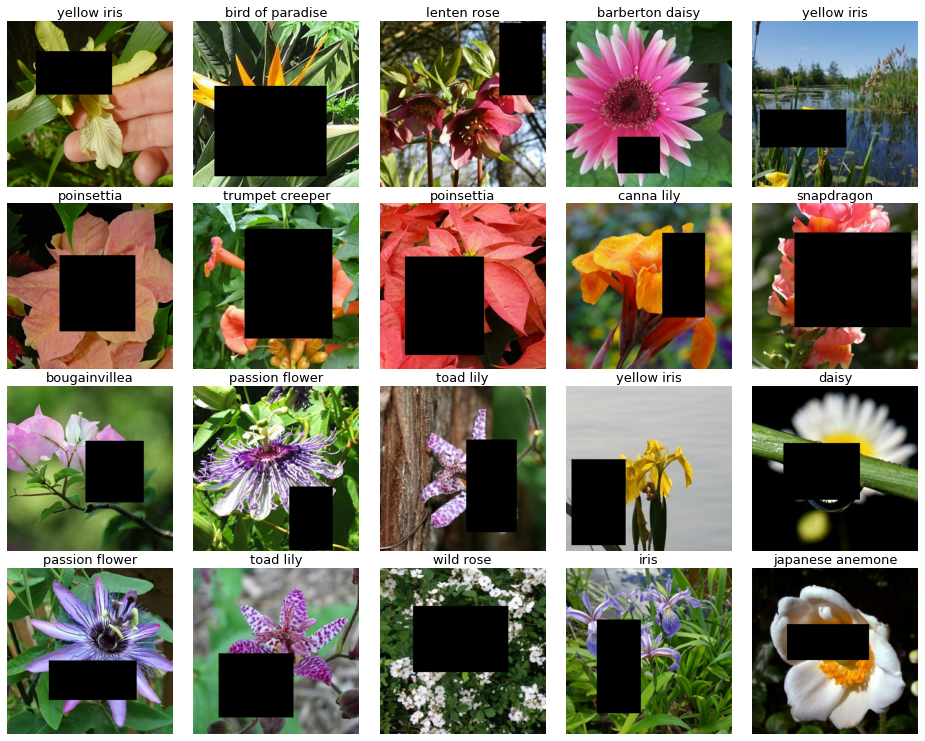

In [14]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

By defining `ds_iter` and `one_batch` in separate cells, you only need to rerun the cell above to see a new batch of images.

# Step 5: Define Model #

Now we're ready to create a neural network for classifying images! We'll use what's known as **transfer learning**. With transfer learning, you reuse part of a pretrained model to get a head-start on a new dataset.

For the starter code, it uses a model called **VGG16** pretrained on [ImageNet](http://image-net.org/)).

The distribution strategy we created earlier contains a [context manager](https://docs.python.org/3/reference/compound_stmts.html#with), `strategy.scope`. This context manager tells TensorFlow how to divide the work of training among the eight TPU cores. When using TensorFlow with a TPU, it's important to define your model in a `strategy.scope()` context.

#### Starter Code ##

```python
with strategy.scope():
    pretrained_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
```

Results from last three epochs are shown: 

* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 24s 238ms/step - loss: 3.4754 - sparse_categorical_accuracy: 0.2208 - val_loss: 3.4896 - val_sparse_categorical_accuracy: 0.2231
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 23s 236ms/step - loss: 3.4629 - sparse_categorical_accuracy: 0.2204 - val_loss: 3.4852 - val_sparse_categorical_accuracy: 0.2239
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 24s 238ms/step - loss: 3.4694 - sparse_categorical_accuracy: 0.2204 - val_loss: 3.4813 - val_sparse_categorical_accuracy: 0.2249

As we can see, the accuracy is about 22%. Although it does converges -- from 5.6% to 20+%, it is far below what we want. Let us try other models. 

### 🔔 Modification 1: Train with Other Models ###
We want to experiment with [other models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) included with Keras. 

In [15]:
# get all the models provided by tf.keras.applications
', '.join(tf.keras.applications.__dir__())

'__name__, __doc__, __package__, __loader__, __spec__, __path__, __file__, __cached__, __builtins__, _sys, densenet, efficientnet, imagenet_utils, inception_resnet_v2, inception_v3, mobilenet, mobilenet_v2, mobilenet_v3, nasnet, resnet, resnet50, resnet_v2, vgg16, vgg19, xception, DenseNet121, DenseNet169, DenseNet201, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, InceptionResNetV2, InceptionV3, MobileNet, MobileNetV2, MobileNetV3Large, MobileNetV3Small, NASNetLarge, NASNetMobile, ResNet101, ResNet152, ResNet50, ResNet101V2, ResNet152V2, ResNet50V2, VGG16, VGG19, Xception'

Below are the code used for training different models. Most are commented out because we only test out one model each time: 

#### Trial 1.1: VGG16() with Trainable = True ####
We will start simple. We stick with VGG16() for now, but we would like to change the ```trainable``` attribute, so that it unfreezes the layers and keep changing the values. Read more [here](https://www.tensorflow.org/guide/keras/transfer_learning).

Initially we also want to increase EPOCHS to 20, but since we have a limitation on how long we can use TPUs for, let us first figure about which model works best before further modifications. 

```python
with strategy.scope():
    # VGG16(), with trainable = True
    vgg16_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )

    vgg16_model.trainable = True
   
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        vgg16_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
```

Results from last three epochs are shown: 
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 41s 411ms/step - loss: 2.9319 - sparse_categorical_accuracy: 0.2498 - val_loss: 2.9557 - val_sparse_categorical_accuracy: 0.2602
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 41s 412ms/step - loss: 2.9168 - sparse_categorical_accuracy: 0.2585 - val_loss: 2.9345 - val_sparse_categorical_accuracy: 0.2683
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 44s 447ms/step - loss: 2.8843 - sparse_categorical_accuracy: 0.2630 - val_loss: 2.8902 - val_sparse_categorical_accuracy: 0.2734

Slight improvements. We are going from 22% to 26%, and the accuracy does increase over epochs. We decided to move on with **```Trainable=True```** for now with other models. 

#### Trial 1.2: VGG19() ####
```python
with strategy.scope():
    # VGG19(), with trainable = True
    vgg19_model = tf.keras.applications.VGG19(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    vgg19_model.trainable = True
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        vgg19_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
```
Results from last three epochs are shown: 
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 45s 452ms/step - loss: 3.6064 - sparse_categorical_accuracy: 0.1462 - val_loss: 3.5898 - val_sparse_categorical_accuracy: 0.1482
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 45s 453ms/step - loss: 3.5920 - sparse_categorical_accuracy: 0.1512 - val_loss: 3.5825 - val_sparse_categorical_accuracy: 0.1509
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 45s 453ms/step - loss: 3.5894 - sparse_categorical_accuracy: 0.1496 - val_loss: 3.5865 - val_sparse_categorical_accuracy: 0.1517

Oh no, the accuracy is worse than before. Let's remove VGG19() out of our list. Next!

#### Trial 1.3: Xception() ####
```python
with strategy.scope():
    # Xception(), with trainable = True
    xception_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    xception_model.trainable = True
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        xception_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
```
Results from last three epochs are shown: 

* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 35s 350ms/step - loss: 0.0113 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.2524 - val_sparse_categorical_accuracy: 0.9402
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 35s 359ms/step - loss: 0.0110 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.2522 - val_sparse_categorical_accuracy: 0.9402
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 35s 351ms/step - loss: 0.0087 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.2525 - val_sparse_categorical_accuracy: 0.9399
 

Wow, 94% accuracy is quite impressive impressive! Because of the accuracy is so high, we moved one step forward, which is evaluating the model with the validation set. Here is the result: 

We will compare this with other models. 


#### Trial 1.4 DenseNet201() ###

There are three different Densenet architectures provided. We decided to use DenseNet201() because it has a larger number attached to it, and that usually means it is developed more recently, so could give us better results. 

```python
with strategy.scope():
    # DenseNet201(), with trainable = True
    densenet_model = tf.keras.applications.densenet.DenseNet201(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        densenet_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
 ```
 Results from last three epochs are shown: 

* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 54s 544ms/step - loss: 0.0245 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.2274 - val_sparse_categorical_accuracy: 0.9445
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 54s 547ms/step - loss: 0.0229 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.2247 - val_sparse_categorical_accuracy: 0.9461
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 54s 546ms/step - loss: 0.0240 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.2258 - val_sparse_categorical_accuracy: 0.9448

Some good training is happening, even compared to Xception()! 

#### Trial 1.5 EfficientNetB7() ####

We would like to play with EfficientNetB7, which seems to perform pretty well according to this [blog](https://www.cnblogs.com/DreamingFishZIHao/p/12982945.html). The good news is, with the upgraded TensorFlow library, EfficientNetB7() is included in keras now.

```python
with strategy.scope():
    # EfficientNetB7()
    efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB7(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        efficientnet_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
```
Results from last three epochs are shown: 

* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 95s 957ms/step - loss: 0.0179 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.3992 - val_sparse_categorical_accuracy: 0.9124
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 94s 952ms/step - loss: 0.0152 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.4293 - val_sparse_categorical_accuracy: 0.9052
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 94s 952ms/step - loss: 0.0161 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.4146 - val_sparse_categorical_accuracy: 0.9089

Pretty good accuracy, but not as good as DenseNet(). Also, the time it needs to train the data is longer compared to DenseNet() or Xception(). 

Then, when experimenting with our ⚖️ modification 2, we came across a [blog](https://towardsdatascience.com/efficient-nets-with-noisy-student-training-5ac6e239ff14), which basically says how the performance can be improved if we changed the value assigned to the ```weights``` attribute. Why not give it a try?

Interestingly, the keras library does not allow us to modify the weights to be 'noisy-student'. So we need to import ```efficientnet``` and go from there. 

```python
with strategy.scope():
    # EfficientNetB7()
    efficientnet_model = efn.EfficientNetB7(
        weights='noisy-student',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        efficientnet_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
```
Results from last three epochs are shown: 
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 94s 948ms/step - loss: 0.0684 - sparse_categorical_accuracy: 0.9823 - val_loss: 0.2297 - val_sparse_categorical_accuracy: 0.9507
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 93s 944ms/step - loss: 0.0649 - sparse_categorical_accuracy: 0.9822 - val_loss: 0.2295 - val_sparse_categorical_accuracy: 0.9504
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 93s 942ms/step - loss: 0.0610 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.2311 - val_sparse_categorical_accuracy: 0.9515

Improved a lot (from 90% to 95%)! It seems like ```noisy-student``` is a better weight to be used for EfficientNetB7(). We will use it from now on. 

#### Trial 1.6: InceptionV3() ####

Another cool architecture with InceptionV3(). 

```python
with strategy.scope():
    # InceptionV3()
    inception_model = tf.keras.applications.inception_v3.InceptionV3(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        inception_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
```
Results from last three epochs are shown: 

* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 32s 326ms/step - loss: 0.0301 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.2770 - val_sparse_categorical_accuracy: 0.9340
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 33s 331ms/step - loss: 0.0295 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.2778 - val_sparse_categorical_accuracy: 0.9348
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 33s 330ms/step - loss: 0.0234 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.2788 - val_sparse_categorical_accuracy: 0.9343

#### Trial 1.7: MobileNetV3Small() ####
Again, there are several options provided by MobileNet: MobileNet(), MobileNetV2(), MobileNetV3Large(), MobileNetV3Small(). 

According to this [research paper](https://arxiv.org/pdf/1905.02244.pdf) from Cornell University, "MobileNetV3-Small is 4.6\% more accurate while reducing latency by 5\% compared to MobileNetV2. MobileNetV3-Large detection is 25\% faster at roughly the same accuracy as MobileNetV2 on COCO detection. MobileNetV3-Large LR-ASPP is 30\% faster than MobileNetV2 R-ASPP at similar accuracy for Cityscapes segmentation." Therefore, we use MobileNetV3Small() for the model. 

```python
with strategy.scope():
    # MobileNetV3Small()
    mobilenet_model = tf.keras.applications.MobileNetV3Small(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        mobilenet_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
```

Results from last three epochs are shown: 

* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 18s 184ms/step - loss: 0.1393 - sparse_categorical_accuracy: 0.9620 - val_loss: 4.8778 - val_sparse_categorical_accuracy: 0.0442
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 18s 184ms/step - loss: 0.1361 - sparse_categorical_accuracy: 0.9641 - val_loss: 4.8564 - val_sparse_categorical_accuracy: 0.0442
- Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 18s 183ms/step - loss: 0.1393 - sparse_categorical_accuracy: 0.9657 - val_loss: 4.9026 - val_sparse_categorical_accuracy: 0.0442

Not sure what exactly is happening, but the model accuracy for validation set is quite low (only 4%). 

#### Trial 1.8: NASNetMobile() ####

Not a lot of papers are found when comparing NASNetMobile() with NasNetLarge(), so we just choose one to do the modeling. Interestingly, we cannot use imagenet as weights now because from the [documentations](https://www.tensorflow.org/api_docs/python/tf/keras/applications/nasnet/NASNetMobile), if it is, then the input_shape must be (224, 224, 3). Since our images are (512, 512, 3) instead, change the weights to be None (random initialization). 
```python
with strategy.scope():
    # NASNetMobile()
    nasnet_model = tf.keras.applications.nasnet.NASNetMobile(
        weights=None, # cannot use imagenet weighte because input_shape is not (224, 224, 3)
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        nasnet_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
```
Results from last three epochs are shown: 

* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 59s 597ms/step - loss: 1.4590 - sparse_categorical_accuracy: 0.6165 - val_loss: 4.4366 - val_sparse_categorical_accuracy: 0.0447
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 59s 598ms/step - loss: 1.4326 - sparse_categorical_accuracy: 0.6142 - val_loss: 4.4375 - val_sparse_categorical_accuracy: 0.0442
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 59s 595ms/step - loss: 1.3871 - sparse_categorical_accuracy: 0.6330 - val_loss: 4.4542 - val_sparse_categorical_accuracy: 0.0439

Again, though the accuracy on training data is around 63%, the performance on validation dataset is not good.

#### Trial 1.9: ResNet152V2() ####

ResNet is a powerful deep neural network tool, where the numbers after "ResNet" just represent differen number of layers.

According to another paper on [ResNet](https://arxiv.org/pdf/1512.03385.pdf), seems like ResNet-152 has the least top-1 and top-5 error rates compared to other shallower ResNet models (such as ResNet50 or ResNet101) for classification on Imagenet validation. Hence, we use ResNet152V2() here. 

```python
with strategy.scope():
    # ResNet152V2()
    resnet_model = tf.keras.applications.resnet_v2.ResNet152V2(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        resnet_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
```
Results from last three epochs are shown:
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 46s 464ms/step - loss: 0.0558 - sparse_categorical_accuracy: 0.9922 - val_loss: 0.3634 - val_sparse_categorical_accuracy: 0.9119
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 46s 463ms/step - loss: 0.0491 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.3672 - val_sparse_categorical_accuracy: 0.9116
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 47s 477ms/step - loss: 0.0437 - sparse_categorical_accuracy: 0.9949 - val_loss: 0.3666 - val_sparse_categorical_accuracy: 0.9111

91%! Pretty good accuracy on the validation set.

### 🔔 Modification 1: Train with Other Models - Comparisons ###

Let's do a quick comparisons for models that perform with an accuracy higher than 85% on validation set:

* Xception(): f1 = 0.936, precision = 0.944, recall = 0.932
* DenseNet201(): f1 = 0.942, precision = 0.944, recall = 0.944
* EfficientNetB7() with weights = 'imagenet': f1 = 0.895, precision = 0.901, recall = 0.895
* InceptionV3(): f1 = 0.925, precision = 0.930, recall = 0.926
* RasNet152V2(): f1 = 0.898, precision = 0.912, recall = 0.891
* (in second modification found) EfficientNetB7() with weights = 'noisy-student': f1 = 0.949, 0.948, 0.955

From the numbers, DenseNet201() provides a good model for training. It also has a relatively fast training speed. 

It is possible to use a mixture of models for predictions, and that will be an improvement to be explored in future modifications. 


The `'sparse_categorical'` versions of the loss and metrics are appropriate for a classification task with more than two labels, like this one.

### 🚀 Modification 3: Optimizers ###

How about optimizers? What are some optimizers that are available and maybe have a better performance?

#### Starter Code ####

```python
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)
```

Because we do have time limitation on running with TPUs, we cannot train on every model that we found in the first modifications. We will start with ```Xception()``` for now because of its faster runtime among all models with relatively high accuracy. 

Before we get started exploring, there is some notes on choosing the optimizers. Even though we have decided to not continue with training with class weights calculated from training dataset, there is still some facts we found out about our data. Namely, our dataset is imbalanced. From this [example on examining imabalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#examine_the_class_label_imbalance), it is mentioned that: 
> Note: Using class_weights changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like tf.keras.optimizers.SGD, may fail. The optimizer used here, tf.keras.optimizers.Adam, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.
<!-- -->

So it is possible that some optimizers will perform worse than Adam, which is okay because we can always go back to it. But let's start experimenting first:

```python
# get all the models provided by tf.keras.applications
', '.join(tf.keras.optimizers.__dir__())

model.compile(
    optimizer='adam',
    # other optimizers are not use due to insignificant improvements
#     optimizer = 'Adadelta',
#     optimizer = 'Adagrad',
#     optimizer = 'Adamax',
#     optimizer = 'Ftrl',
#     optimizer = 'Nadam',
#     optimizer = 'RMSprop',
#     optimizer = 'SGD',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)
```

#### Trial 3.0 Adam - Xception() ####
This is the last three epochs from 🔔 modification 1:
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 35s 350ms/step - loss: 0.0113 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.2524 - val_sparse_categorical_accuracy: 0.9402
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 35s 359ms/step - loss: 0.0110 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.2522 - val_sparse_categorical_accuracy: 0.9402
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 35s 351ms/step - loss: 0.0087 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.2525 - val_sparse_categorical_accuracy: 0.9399

#### Trial 3.1 Adadelta - Xception() ####
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 35s 352ms/step - loss: 4.5748 - sparse_categorical_accuracy: 0.0152 - val_loss: 4.5683 - val_sparse_categorical_accuracy: 0.0180
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 35s 352ms/step - loss: 4.5681 - sparse_categorical_accuracy: 0.0162 - val_loss: 4.5681 - val_sparse_categorical_accuracy: 0.0183
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 39s 394ms/step - loss: 4.5749 - sparse_categorical_accuracy: 0.0153 - val_loss: 4.5677 - val_sparse_categorical_accuracy: 0.0189

No luck here. All the evaluations are pretty low (1%, seriously?). Next!

#### Trial 3.2 Adagrad - Xception() ####
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 34s 348ms/step - loss: 4.1973 - sparse_categorical_accuracy: 0.1020 - val_loss: 4.1869 - val_sparse_categorical_accuracy: 0.1048
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 36s 359ms/step - loss: 4.1956 - sparse_categorical_accuracy: 0.1079 - val_loss: 4.1858 - val_sparse_categorical_accuracy: 0.1064
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 35s 358ms/step - loss: 4.1915 - sparse_categorical_accuracy: 0.1073 - val_loss: 4.1826 - val_sparse_categorical_accuracy: 0.1048

Better, but not actually. 10% is still pretty low. 

#### Trial 3.3 Adamax - Xception() ####
*  Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 35s 352ms/step - loss: 0.0413 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.2505 - val_sparse_categorical_accuracy: 0.9348
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 35s 354ms/step - loss: 0.0395 - sparse_categorical_accuracy: 0.9966 - val_loss: 0.2509 - val_sparse_categorical_accuracy: 0.9356
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 36s 366ms/step - loss: 0.0397 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.2505 - val_sparse_categorical_accuracy: 0.9353

Much better results compared to the previous two. Therefore, we continue the evaluation process to get its f1, precision, and recall.

#### Trial 3.4 Ftrl - Xception() ####
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 35s 352ms/step - loss: 4.6439 - sparse_categorical_accuracy: 0.0651 - val_loss: 4.6438 - val_sparse_categorical_accuracy: 0.0614
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 35s 351ms/step - loss: 4.6439 - sparse_categorical_accuracy: 0.0613 - val_loss: 4.6439 - val_sparse_categorical_accuracy: 0.0614
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 35s 352ms/step - loss: 4.6439 - sparse_categorical_accuracy: 0.0591 - val_loss: 4.6439 - val_sparse_categorical_accuracy: 0.0614

Too bad, guess we have to throw this one away as well. 

#### Trial 3.5 Nadam - Xception() ####
* Epoch 00009: LearningRateScheduler reducing learning rate to 3.0480000000000006e-05. 99/99 [==============================] - 36s 365ms/step - loss: 0.0097 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.2293 - val_sparse_categorical_accuracy: 0.9448
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 35s 354ms/step - loss: 0.0089 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.2297 - val_sparse_categorical_accuracy: 0.9445
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 35s 350ms/step - loss: 0.0083 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.2318 - val_sparse_categorical_accuracy: 0.9448
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 35s 358ms/step - loss: 0.0076 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.2319 - val_sparse_categorical_accuracy: 0.9459

Something nice is happening!

#### Trial 3.6 RMSprop - Xception() ####
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 34s 347ms/step - loss: 0.0046 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.2784 - val_sparse_categorical_accuracy: 0.9407
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 35s 354ms/step - loss: 0.0031 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.2741 - val_sparse_categorical_accuracy: 0.9423
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 35s 352ms/step - loss: 0.0022 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.2750 - val_sparse_categorical_accuracy: 0.9421

Also great job. Proceed with computing f1, precision, and recall. 

#### Trial 3.7 SGD - Xception() ####
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 34s 343ms/step - loss: 3.6998 - sparse_categorical_accuracy: 0.2574 - val_loss: 3.6428 - val_sparse_categorical_accuracy: 0.2740
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 34s 343ms/step - loss: 3.6812 - sparse_categorical_accuracy: 0.2606 - val_loss: 3.6416 - val_sparse_categorical_accuracy: 0.2729
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 34s 346ms/step - loss: 3.6767 - sparse_categorical_accuracy: 0.2592 - val_loss: 3.6417 - val_sparse_categorical_accuracy: 0.2737

Not good. Let's put it away.


### 🚀 Modification 3: Optimizers - Comparisons ###

Again, let's do a comparison of the optimizers with relatively high accuracy on validation set:

Recall that we only train these different optimizers on one model Xception(), which can give different results when trained with DenseNet201() or EfficientNetB7(). That can be a topic to be explored later on. 

* Adam: f1 = 0.936, precision = 0.944, recall = 0.932
* Adamax: f1 = 0.921, precision = 0.933, recall = 0.918
* Nadam: f1 = 0.937, precision = 0.942, recall = 0.936
* RMSprop: f1 = 0.937, precision = 0.941, recall = 0.937

The improvements by changing the optimizers is not significant either. Since we cannot predict how the optimizers will perform on DenseNet201() and EfficientNetB7(), we will stick with ```Adam```, which we know for sure that have a good performance on the other two models. 

# Step 6: Training #

## Learning Rate Schedule ##

We'll train this network with a special learning rate schedule.

Learning rate schedule: 1e-05 to 5e-05 to 2.05e-05


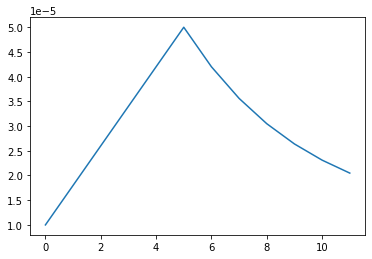

In [16]:
EPOCHS = 12

# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Fit Model ##

And now we're ready to train the model. After defining a few parameters, we're good to go!

In [17]:
# Define training epochs
EPOCHS = 12
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

### ⚖️ Modification 2: Calculate Weights ###

Inside ```model.fit()```, there is an attribute called ```class_weight```. According to Keras [doc](https://keras.io/models/sequential/): this attribute is an "optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only)". It is set up for [classification on imbalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data). 

The general idea is that since we do not have many samples for those less represented classes, we should have the classifer weight heavily on those few examples that are available. In other words, we want the models to "pay more attention" to example from an under-represented class. 

Maybe we can customize this attribute? Let us start by looking at the dataset imbalance:

```python
from collections import Counter
import gc
gc.enable()

training_data_copy = load_dataset(TRAINING_FILENAMES, labeled = True, ordered = False)

label_counter = Counter()
for images, labels in training_data_copy:
    label_counter.update([labels.numpy()])

del training_data_copy

TARGET_NUM_PER_CLASS = NUM_TRAINING_IMAGES / 104 # if balanced, every class should have about 122 images

def get_weight_for_class(class_id):
    counting = label_counter[class_id]
    weight = TARGET_NUM_PER_CLASS / counting
    return weight

training_class_weights = {class_id: get_weight_for_class(class_id) for class_id in range(104)}
```

A quick graph to show different weights (code from this [notebook](https://www.kaggle.com/georgezoto/computer-vision-petals-to-the-metal/notebook#Step-5:-Define-Model)):
```python
import seaborn as sns
from matplotlib import cm

data = pd.DataFrame.from_dict(training_class_weights, orient='index', columns=['class_weight'])
plt.figure(figsize=(30, 9))

#barplot color based on value
bplot = sns.barplot(x=data.index, y='class_weight', data=data, palette= cm.Blues(data['class_weight']*0.15));
for p in bplot.patches:
    bplot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Class", size=14)
plt.ylabel("Class weight (inverse of %)", size=14)
```

Let's train the model with class weights and evaluate it now. See if it affects our predictions.

We pick the models that perform pretty well in the last round: Xception(), DenseNet201(), EfficientNetB7(), Inception2(), and RasNet152V2().

```python
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
    # modification 2: class weights (abandoned because no improvements)
    # class_weight = training_class_weights
)
```

The last three epochs for each models are shown below:

#### Trial 2.1 Xception() ####
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 35s 357ms/step - loss: 0.0211 - sparse_categorical_accuracy: 0.9918 - val_loss: 0.2537 - val_sparse_categorical_accuracy: 0.9386
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 36s 361ms/step - loss: 0.0201 - sparse_categorical_accuracy: 0.9919 - val_loss: 0.2517 - val_sparse_categorical_accuracy: 0.9378
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 35s 351ms/step - loss: 0.0217 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.2528 - val_sparse_categorical_accuracy: 0.9386

#### Trial 2.2 DenseNet201() ####
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 66s 668ms/step - loss: 0.0612 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.2711 - val_sparse_categorical_accuracy: 0.9337
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 54s 544ms/step - loss: 0.0562 - sparse_categorical_accuracy: 0.9817 - val_loss: 0.2689 - val_sparse_categorical_accuracy: 0.9337
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 54s 549ms/step - loss: 0.0520 - sparse_categorical_accuracy: 0.9824 - val_loss: 0.2669 - val_sparse_categorical_accuracy: 0.9356


#### Trial 2.3 EfficientNetB7() with weights = 'imagenet' ####
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 95s 956ms/step - loss: 0.0461 - sparse_categorical_accuracy: 0.9766 - val_loss: 0.4328 - val_sparse_categorical_accuracy: 0.8955
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 94s 948ms/step - loss: 0.0440 - sparse_categorical_accuracy: 0.9759 - val_loss: 0.4292 - val_sparse_categorical_accuracy: 0.8963
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 94s 951ms/step - loss: 0.0380 - sparse_categorical_accuracy: 0.9803 - val_loss: 0.4328 - val_sparse_categorical_accuracy: 0.8947

#### Trial 2.4 InceptionV2() ####
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 32s 325ms/step - loss: 0.0986 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.3714 - val_sparse_categorical_accuracy: 0.9068
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 32s 323ms/step - loss: 0.0846 - sparse_categorical_accuracy: 0.9621 - val_loss: 0.3675 - val_sparse_categorical_accuracy: 0.9079
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 32s 328ms/step - loss: 0.0790 - sparse_categorical_accuracy: 0.9633 - val_loss: 0.3650 - val_sparse_categorical_accuracy: 0.9062


#### Trial 2.5 RasNet152V2() ####
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 46s 467ms/step - loss: 0.3368 - sparse_categorical_accuracy: 0.8629 - val_loss: 0.7441 - val_sparse_categorical_accuracy: 0.8079
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 46s 464ms/step - loss: 0.3156 - sparse_categorical_accuracy: 0.8659 - val_loss: 0.7330 - val_sparse_categorical_accuracy: 0.8093
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 46s 462ms/step - loss: 0.2884 - sparse_categorical_accuracy: 0.8798 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.8155

#### Trial 2.6 EfficientNetB7() with weights = 'noisy-student' ####
* Epoch 00010: LearningRateScheduler reducing learning rate to 2.6384000000000004e-05. 99/99 [==============================] - 94s 947ms/step - loss: 0.1077 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.2795 - val_sparse_categorical_accuracy: 0.9405
* Epoch 00011: LearningRateScheduler reducing learning rate to 2.3107200000000005e-05. 99/99 [==============================] - 94s 948ms/step - loss: 0.1126 - sparse_categorical_accuracy: 0.9487 - val_loss: 0.2788 - val_sparse_categorical_accuracy: 0.9405
* Epoch 00012: LearningRateScheduler reducing learning rate to 2.0485760000000004e-05. 99/99 [==============================] - 94s 947ms/step - loss: 0.0948 - sparse_categorical_accuracy: 0.9512 - val_loss: 0.2755 - val_sparse_categorical_accuracy: 0.9418


### ⚖️ Modification 2: Calculate Weights - Comparisons ###

Another quick comparison on f1, precision, and recall (before -> after applying class weights): 
* Xception(): f1 = 0.936 -> 0.941, precision = 0.944 -> 0.940, recall = 0.932 -> 0.946
* DenseNet201(): f1 = 0.942 -> 0.935, precision = 0.944 -> 0.931, recall = 0.944 -> 0.944
* EfficientNetB7() with weights = 'imagenet': f1 = 0.895 -> 0.901, precision = 0.901 -> 0.894, recall = 0.895 -> 0.914
* InceptionV3(): f1 = 0.925 -> 0.907, precision = 0.930 -> 0.899, recall = 0.926 -> 0.922
* RasNet152V2(): f1 = 0.898 -> 0.812, precision = 0.912 -> 0.801, recall = 0.891 -> 0.893
* EfficientNetB7() with weights = 'noisy-student': f1 = 0.949 -> 0.941, 0.948 -> 0.932, 0.955 -> 0.955

From the results, we can see that not everything is improved with customized weights. Even when there is an improvement, the change is quite small. Therefore, we are not going to use training_class_weights in future iterations. 

We also decide to remove EfficientNetB7() with weights = 'imagenet', InceptionV3() and RasNet152V2() from the list of usable models because their accuracy is the relatively low among all in both rounds now. 

Even though this modification is not applicable, we are able to find a better model when changing the weights for EfficientNetB7(). Worth it!

### Loss and Metrics ###

This next cell shows how the loss and metrics progressed during training.

```python
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)
```

### 🎨 Modification 4: Mixing Models ###

Inspired by this [notebook](https://www.kaggle.com/wrrosa/tpu-enet-b7-densenet#Finding-best-alpha), we want to try out mix and match models together. We have reduced our models to 3 now (Xception(), DenseNet201(), and EfficientNetB7()), so there will be 2! = 3 combinations of models. Let's examine each pair, and compare their performance.

**Combo 1: Xception() + DenseNet201()**

```python
with strategy.scope():
    # Model 1: Xception()
    # Xception(), with trainable = True
    xception_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    xception_model.trainable = True
    
    model1 = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        xception_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    # Model 2: DenseNet201()
    # DenseNet201(), with trainable = True
    densenet_model = tf.keras.applications.densenet.DenseNet201(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    
    model2 = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        densenet_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
```

**Combo 2: Xception() + EfficientNetB7()**

```python
with strategy.scope():
    # Model 1: Xception()
    # Xception(), with trainable = True
    xception_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    xception_model.trainable = True
    
    model1 = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        xception_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    # Model 2: EfficientNetB7()
    efficientnet_model = efn.EfficientNetB7(
        weights='noisy-student',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    
    model2 = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        efficientnet_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
```

**Combo 3: DenseNet201() + EfficientNetB7()**

```python
with strategy.scope():
    # Model 1: DenseNet201()
    # DenseNet201(), with trainable = True
    densenet_model = tf.keras.applications.densenet.DenseNet201(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    
    model1 = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        densenet_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    # Model 2: EfficientNetB7()
    efficientnet_model = efn.EfficientNetB7(
        weights='noisy-student',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    
    model2 = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        efficientnet_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
```

In [18]:

with strategy.scope():
    # Model 1: Xception()
    # Xception(), with trainable = True
    xception_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    xception_model.trainable = True
    
    model1 = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        xception_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    # Model 2: EfficientNetB7()
    efficientnet_model = efn.EfficientNetB7(
        weights='noisy-student',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    
    model2 = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        efficientnet_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

258072576/258068648 [==============================] - 2s 0us/step


Now that we have defined the two models we want to mix, we need to train the models separately. 

Epoch 1/12

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
99/99 [==============================] - 90s 471ms/step - loss: 2.5838 - sparse_categorical_accuracy: 0.4411 - val_loss: 1.8421 - val_sparse_categorical_accuracy: 0.5288


2022-03-08 20:17:14.714558: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 81804, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1646770634.714436607","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 81804, Output num: 0","grpc_status":3}


Epoch 2/12

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008100000379979611.
99/99 [==============================] - 37s 371ms/step - loss: 0.7086 - sparse_categorical_accuracy: 0.8174 - val_loss: 0.6762 - val_sparse_categorical_accuracy: 0.8244
Epoch 3/12

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005060000335611404.
99/99 [==============================] - 36s 366ms/step - loss: 0.3831 - sparse_categorical_accuracy: 0.8970 - val_loss: 0.3377 - val_sparse_categorical_accuracy: 0.9114
Epoch 4/12

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00023240000449121004.
99/99 [==============================] - 36s 364ms/step - loss: 0.2018 - sparse_categorical_accuracy: 0.9458 - val_loss: 0.2545 - val_sparse_categorical_accuracy: 0.9359
Epoch 5/12

Epoch 00005: LearningRateScheduler reducing learning rate to 8.648000176530332e-05.
99/99 [==============================] - 36s 367ms/step - loss: 0.1321 - sparse_categorical_accuracy: 0.9

2022-03-08 20:29:10.641017: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 123940, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1646771350.640349811","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 123940, Output num: 1","grpc_status":3}


Epoch 2/12

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008100000379979611.
99/99 [==============================] - 96s 968ms/step - loss: 0.9146 - sparse_categorical_accuracy: 0.7527 - val_loss: 0.5286 - val_sparse_categorical_accuracy: 0.8688
Epoch 3/12

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005060000335611404.
99/99 [==============================] - 96s 967ms/step - loss: 0.5295 - sparse_categorical_accuracy: 0.8558 - val_loss: 0.3456 - val_sparse_categorical_accuracy: 0.9208
Epoch 4/12

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00023240000449121004.
99/99 [==============================] - 96s 968ms/step - loss: 0.3335 - sparse_categorical_accuracy: 0.9103 - val_loss: 0.2369 - val_sparse_categorical_accuracy: 0.9477
Epoch 5/12

Epoch 00005: LearningRateScheduler reducing learning rate to 8.648000176530332e-05.
99/99 [==============================] - 96s 971ms/step - loss: 0.2372 - sparse_categorical_accuracy: 0.9

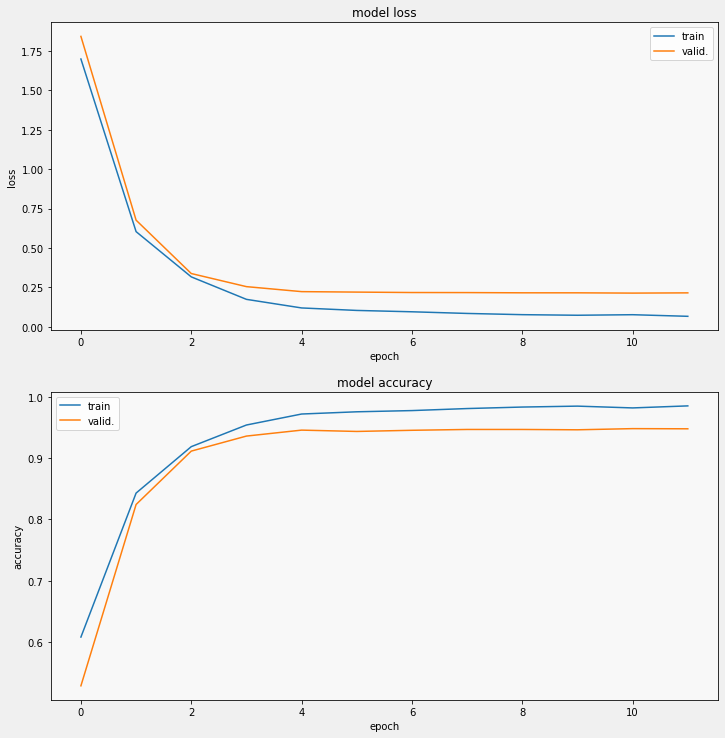

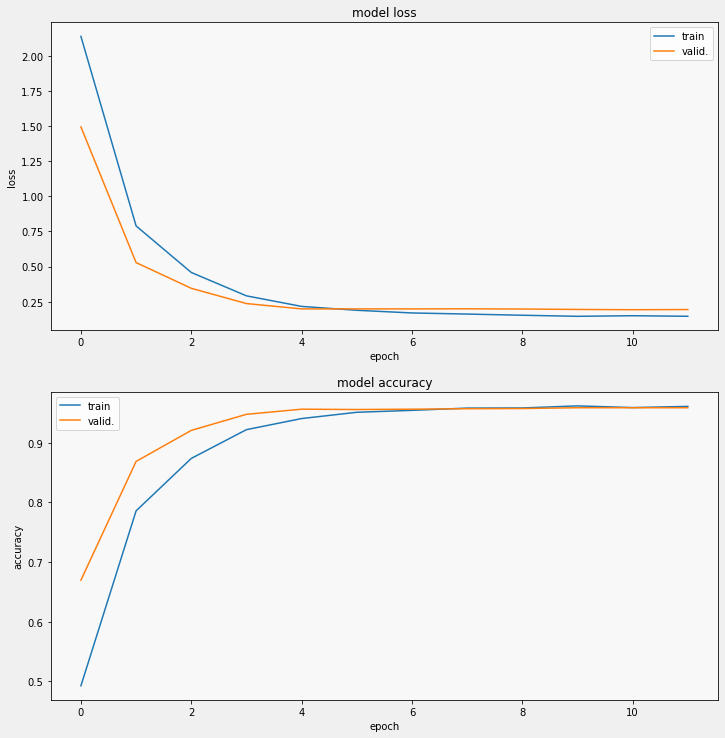

In [19]:
# train model 1
model1.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

history = model1.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)

# display curves for model 1
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

# train model 2
model2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

history2 = model2.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)

# display curves for model 2
display_training_curves(
    history2.history['loss'],
    history2.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history2.history['sparse_categorical_accuracy'],
    history2.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

Next, we need to find the best_alpha to set the weight between the two models. We adapted the code from this [notebook](https://www.kaggle.com/wrrosa/tpu-enet-b7-densenet#Finding-best-alpha) on how to calculate the alpha that works the best. 

In [20]:
# Code adpated from: https://www.kaggle.com/wrrosa/tpu-enet-b7-densenet#Finding-best-alpha
from sklearn.metrics import f1_score
def find_best_alpha(model_lst):
    # get validation dataset; because we are splitting the dataset and iterating separately on images and labels, order matters.
    valid_data = get_validation_dataset(ordered=True)
    images_data = valid_data.map(lambda image, label: image)
    labels_data = valid_data.map(lambda image, label: label).unbatch()
    valid_true_labels = next(iter(labels_data.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
    
    # make predictions based on given models
    pred = []
    for model in model_lst:
        pred.append(model.predict(images_data))

    scores = []
    for alpha in np.linspace(0,1,100):
        preds = np.argmax(alpha * pred[0]+ (1-alpha) * pred[1], axis=-1)
        scores.append(f1_score(valid_true_labels, preds, labels=range(len(CLASSES)), average='macro'))

    best_alpha = np.argmax(scores)/100
    return best_alpha

models = []
models.append(model1)
models.append(model2)
best_alpha = find_best_alpha(models)
print(best_alpha)

2022-03-08 20:47:03.700212: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 136983, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1646772423.700017214","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 136983, Output num: 0","grpc_status":3}


0.5


### 🎨 Modification 4: Mixing Models - Comparisons ###
Let's do another round of comparisons on these three combinations:
* Xception() + DenseNet201(): f1 = 0.95, precision = 0.952, recall = 0.952
* Xception() + EfficientNetB7(): f1 = 0.961, precision = 0.962, recall = 0.962
* DenseNet201() + EfficientNetB7(): f1 = 0.956, precision = 0.954, recall = 0.960

Seems like the Xception() + EfficientNetB7() performs the best. Let's submit that! Indeed, the combination of Xception() and EfficientNetB7() gives us the best result we have so far -- a score of **0.95303**!

As for reference, the score by submitting DenseNet201() + EfficientNetB7() is 0.94967, which is also pretty good, but not as big as an improvement compared to the combination above: Xception() + EfficientNetB7(). We will stick with this combo for now.

# Step 7: Evaluate Predictions #

Before making your final predictions on the test set, it's a good idea to evaluate your model's predictions on the validation set. This can help you diagnose problems in training or suggest ways your model could be improved. We'll look at two common ways of validation: plotting the **confusion matrix** and **visual validation**.

In [21]:

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## Confusion Matrix ##

A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) shows the actual class of an image tabulated against its predicted class. It is one of the best tools you have for evaluating the performance of a classifier.

The following cell does some processing on the validation data and then creates the matrix with the `confusion_matrix` function included in [`scikit-learn`](https://scikit-learn.org/stable/index.html).

In [22]:
cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
# Modification 4: mix two models
cm_prob1 = model1.predict(images_ds)
cm_prob2 = model2.predict(images_ds)
cm_probabilities = best_alpha * cm_prob1 + (1 - best_alpha) * cm_prob2
# cm_probabilities = model.predict(images_ds) # starter code
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

You might be familiar with metrics like [F1-score](https://en.wikipedia.org/wiki/F1_score) or [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). This cell will compute these metrics and display them with a plot of the confusion matrix. (These metrics are defined in the Scikit-learn module `sklearn.metrics`; we've imported them in the helper script for you.)

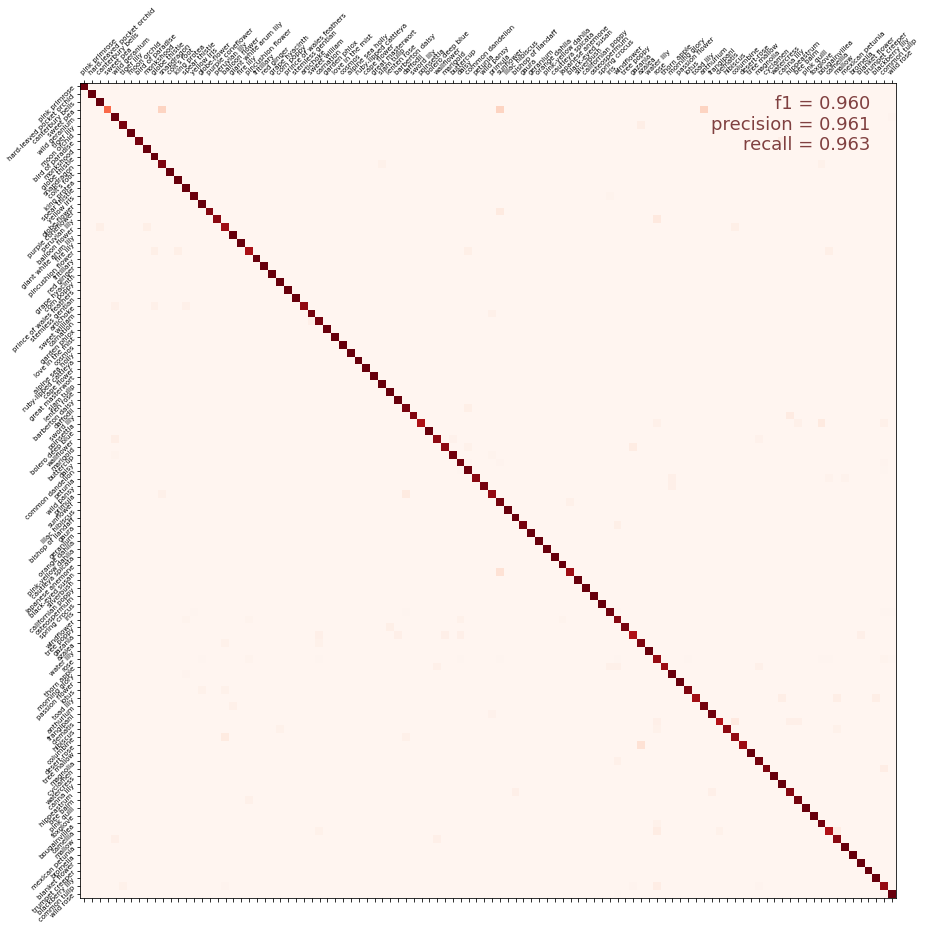

In [23]:
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

## Visual Validation ##

It can also be helpful to look at some examples from the validation set and see what class your model predicted. This can help reveal patterns in the kinds of images your model has trouble with.

This cell will set up the validation set to display 20 images at a time -- you can change this to display more or fewer, if you like.

In [24]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

And here is a set of flowers with their predicted species. Run the cell again to see another set.

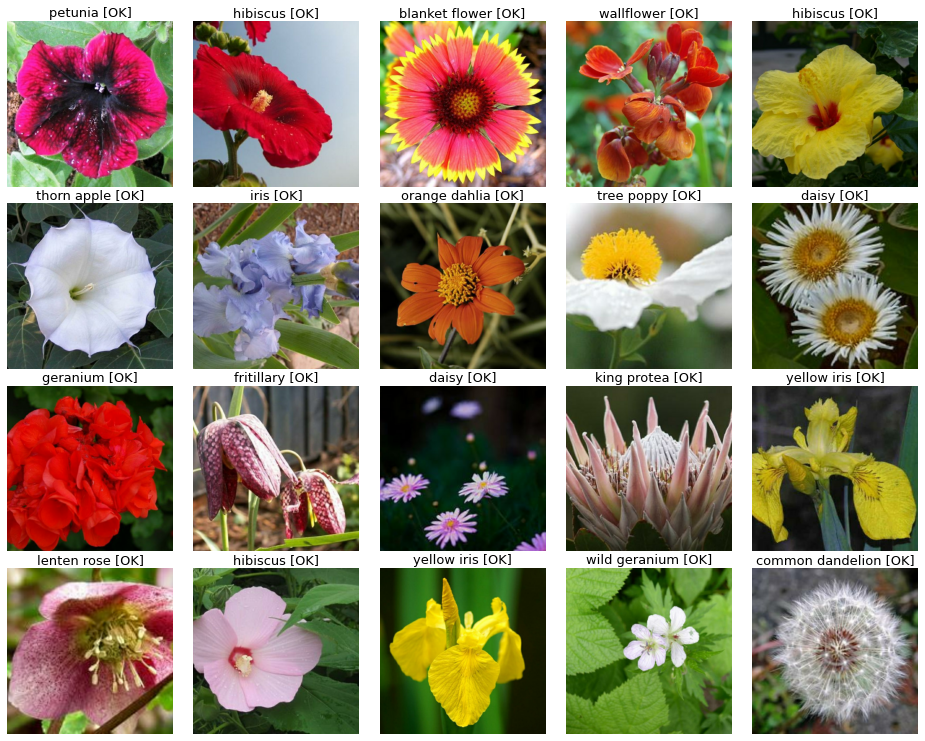

In [25]:
images, labels = next(batch)
# Modification 4
prob1 = model1.predict(images)
prob2 = model2.predict(images)
# probabilities = model.predict(images)
probabilities = best_alpha * prob1 + (1 - best_alpha) * prob2
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

# Step 8: Make Test Predictions #

Once you're satisfied with everything, you're ready to make predictions on the test set.

In [26]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
# Modification 4: mix the two models
prob1 = model1.predict(test_images_ds)
prob2 = model2.predict(test_images_ds)
probabilities = best_alpha * prob1 + (1 - best_alpha) * prob2
# probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...


2022-03-08 20:48:43.181413: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 138687, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1646772523.180868322","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 138687, Output num: 0","grpc_status":3}


[ 67  28  83 ...  53 102  62]


We'll generate a file `submission.csv`. This file is what you'll submit to get your score on the leaderboard.

In [27]:
print('Generating submission.csv file...')

# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

Generating submission.csv file...
id,label
252d840db,67
1c4736dea,28
c37a6f3e9,83
00e4f514e,103
59d1b6146,46
8d808a07b,53
aeb67eefb,52
53cfc6586,29
aaa580243,82


# Step 9: Make a submission #

If you haven't already, create your own editable copy of this notebook by clicking on the **Copy and Edit** button in the top right corner. Then, submit to the competition by following these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!


# Step 10 Potential Modifications #

We listed some modifications that can be made for better results:

### Potential Modification 1: Incorporate external data ###

In one of the top-rated notebook [FC Ensemble External Data (EffNet+DenseNet)](https://www.kaggle.com/atamazian/fc-ensemble-external-data-effnet-densenet), it mentions how using external data can increase model’s accuracy. This makes a lot of sense theoretically since with more training data, we can refine the classifier. So let’s add in more [data](https://www.kaggle.com/kirillblinov/tf-flower-photo-tfrec)!

In Kaggle notebook, that means we need to open the right hand column and add data to it. Search for the ```tf-flower-photo-tfrec``` dataset and add it!

Now run the next cell, you shall see both dataset presented. 

```python
# list datasets
ls /kaggle/input

# load in external data
GCS_DS_PATH_EXT = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')
GCS_PATH_EXT = '/tfrecords-jpeg-512x512' # choose 512*512 again thanks to TPUs

# five different folders are provided in the dataset, load separatly
IMAGENET_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/imagenet' + GCS_PATH_EXT + '/*.tfrec')
INATURALIST_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/inaturalist' + GCS_PATH_EXT + '/*.tfrec')
OPENIMAGE_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/openimage' + GCS_PATH_EXT + '/*.tfrec')
OXFORD_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/oxford_102' + GCS_PATH_EXT + '/*.tfrec')
TFFLOWERS_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/tf_flowers' + GCS_PATH_EXT + '/*.tfrec')

EXTRA_TRAINING_FILENAMES = IMAGENET_FILENAMES + INATURALIST_FILENAMES + OPENIMAGE_FILENAMES + OXFORD_FILENAMES + TFFLOWERS_FILENAMES

# add extra training to the existing training dataset
TRAINING_FILENAMES = TRAINING_FILENAMES + EXTRA_TRAINING_FILENAMES
```

Original Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images

With Extra Training Dataset: 68094 training images, 3712 validation images, 7382 unlabeled test images

That is a lot of new data added! We go from 12k to 68k now. The time for training for sure is going to go up.

### Potential Modification 2: Increase EPOCHS ###

Right now, the number of EPOCHS is set to 12, which is given in the starter code. We stick with 12 for this iteration because if we try more EPOCHS, the time needed to train will increase. 

Since Kaggle has a limitation on 20 hours of TPUs/week, we do not want to spend too much time on "picking the models" round. We might increase EPOCHS if it does give us better classifer in future iterations though. 

### Potential Modification 3: Find Best Optimizer for Each Model ###
In 🚀 modification 3, we experiment with different optimizers on Xception() model, and use the result as a general rule for other models as well. This may not be true, though. If time allows, we will also figure out the best optimizer for each of Xception(), DenseNet201() and EfficientNetB7(). 